In [1]:
import logging
import re
import sys
from os import listdir
from os.path import abspath, join

import geopandas as gpd
import geoplot as gplt
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from rasterio.features import shapes
from interviz.helpers.raster_to_polygons import disaggregate_viewsheds_and_convert_to_polygons

logging.basicConfig(stream=sys.stderr, level=logging.INFO)
logger = logging.getLogger('__name__')

% matplotlib inline

In [2]:
%pwd

'/home/joshainglis/other_projects/papers/isea_interviz'

## Read in shapefiles

In [27]:
viewpoints = gpd.read_file("data/sl_-85/gridded_viewpoints.shp")
viewpoints['FID'] = viewpoints.FID_split - 1
viewpoints = viewpoints[['FID']].set_index('FID', drop=False, verify_integrity=True)

islands = gpd.read_file('data/sl_-85/islands.shp')
islands['FID'] = islands.Id - 1
islands = islands.set_index('FID', drop=False, verify_integrity=True)
islands.to_file("data/sl_-85/islands_fixed.shp")

split_islands = gpd.read_file("data/sl_-85/split_islands.shp")
split_islands['FID_island'] = split_islands.Id - 1

joined_viewpoints = viewpoints.join(split_islands[['FID_island']], on='FID', how='inner', lsuffix='_point', rsuffix='_split')
# joined_viewpoints = joined_viewpoints[['FID_island', 'FID_point', 'Z', 'geometry']]

# island_viewpoints = joined_viewpoints.join(islands, on='FID_island', lsuffix='_point', rsuffix='_island')
# island_viewpoints.to_file("data/sl_-85/island_viewpoints.shp")

In [32]:
viewpoints.head(30)

FID_grid  FID_island  FID_split    Z  \
FID                                         
0          26        2983          1  161   
1          35        3206          2  289   
2          29        3136          3  227   
3          30        3137          4   87   
4          18        1949          5  166   
5          24        2968          6   10   
6          33        3173          7    4   
7          33        3174          8    4   
8          32        3172          9    1   
10         33        3182         11    5   
12         72        3175         13    1   
13         33        3176         14    7   
14         73        3183         15    7   
15         73        3184         16    6   
16         73        3178         17    2   
17         73        3179         18    3   
18          8        1660         19   28   
19         48        1661         20    0   
20         63        2992         21   54   
21         72        3190         22    6   
22         72        3191         23   10   
23         62        2984         24    0   
24         62        2985         25    0   
25         33        3180         26  -77   
26         73        3196         27  209   
27         62        2986         28    8   
28         35        3207         29  158   
29         36        3208         30   70   
30         75        3220         31  162   
31         61        2944         32   11   

                                              geometry  FID  
FID                                                          
0    POINT Z (125.7439858986305 -8.024643901794548 ...    0  
1    POINT Z (129.7289858985805 -8.024643901794548 ...    1  
2    POINT Z (127.1739858988302 -8.044643901394863 ...    2  
3    POINT Z (127.2189858983807 -8.094643901294887 87)    3  
4    POINT Z (122.1314858986553 -8.112143901619731 ...    4  
5    POINT Z (124.6189858981809 -8.119643901245013 10)    5  
6     POINT Z (128.6814858981559 -8.149643901544778 4)    6  
7     POINT Z (128.6839858983307 -8.152143901719569 4)    7  
8     POINT Z (128.5614858987554 -8.159643901344907 1)    8  
10    POINT Z (128.7489858983806 -8.159643901344907 5)   10  
12    POINT Z (128.5639858989301 -8.162143901519812 1)   12  
13    POINT Z (128.7389858985804 -8.159643901344907 7)   13  
14    POINT Z (128.7389858985804 -8.162143901519812 7)   14  
15    POINT Z (128.7514858985555 -8.162143901519812 6)   15  
16    POINT Z (128.5764858989052 -8.162143901519812 2)   16  
17     POINT Z (128.5889858988802 -8.16464390169466 3)   17  
18   POINT Z (117.4039858989303 -8.132143901219933 28)   18  
19    POINT Z (117.3789858989802 -8.162143901519812 0)   19  
20   POINT Z (124.3739858981307 -8.179643901844543 54)   20  
21    POINT Z (128.3889858983806 -8.194643901095105 6)   21  
22   POINT Z (128.4114858981558 -8.192143901819577 10)   22  
23    POINT Z (124.0339858986304 -8.209643901244988 0)   23  
24    POINT Z (124.0364858988053 -8.212143901419836 0)   24  
25   POINT Z (128.6664858989053 -8.159643901344907 ...   25  
26   POINT Z (128.6964858983056 -8.172143901319942 ...   26  
27    POINT Z (124.0439858984305 -8.214643901594741 8)   27  
28   POINT Z (129.8589858986804 -8.159643901344907 ...   28  
29    POINT Z (129.9189858983806 -8.10464390109513 70)   29  
30   POINT Z (129.8564858985055 -8.162143901519812 ...   30  
31   POINT Z (123.3239858984306 -8.232143901020152 11)   31

In [28]:
joined_viewpoints.head()

FID_grid  FID_island_point  FID_split    Z  \
FID                                               
0          26              2983          1  161   
1          35              3206          2  289   
2          29              3136          3  227   
3          30              3137          4   87   
4          18              1949          5  166   

                                              geometry  FID  FID_island_split  
FID                                                                            
0    POINT Z (125.7439858986305 -8.024643901794548 ...    0                 0  
1    POINT Z (129.7289858985805 -8.024643901794548 ...    1                 1  
2    POINT Z (127.1739858988302 -8.044643901394863 ...    2                 2  
3    POINT Z (127.2189858983807 -8.094643901294887 87)    3                 2  
4    POINT Z (122.1314858986553 -8.112143901619731 ...    4                 3

In [25]:
island_viewpoints.head()

FID_island  FID_island    Z  \
FID                                
0             0           0  161   
1             1           1  289   
2             2           2  227   
3             2           2   87   
4             3           3  166   

                                              geometry  
FID                                                     
0    POINT Z (125.7439858986305 -8.024643901794548 ...  
1    POINT Z (129.7289858985805 -8.024643901794548 ...  
2    POINT Z (127.1739858988302 -8.044643901394863 ...  
3    POINT Z (127.2189858983807 -8.094643901294887 87)  
4    POINT Z (122.1314858986553 -8.112143901619731 ...

In [24]:
joined_viewpoints.head()

FID_grid  FID_island_points  FID_split    Z  \
FID                                                
0          26               2983          1  161   
1          35               3206          2  289   
2          29               3136          3  227   
3          30               3137          4   87   
4          18               1949          5  166   

                                              geometry  FID  FID_island_split  
FID                                                                            
0    POINT Z (125.7439858986305 -8.024643901794548 ...    0                 0  
1    POINT Z (129.7289858985805 -8.024643901794548 ...    1                 1  
2    POINT Z (127.1739858988302 -8.044643901394863 ...    2                 2  
3    POINT Z (127.2189858983807 -8.094643901294887 87)    3                 2  
4    POINT Z (122.1314858986553 -8.112143901619731 ...    4                 3

In [11]:
island_viewpoints.head()

FID_island    Z                                           geometry
FID                                                                    
0             0  161  POINT Z (125.7439858986305 -8.024643901794548 ...
1             1  289  POINT Z (129.7289858985805 -8.024643901794548 ...
2             2  227  POINT Z (127.1739858988302 -8.044643901394863 ...
3             2   87  POINT Z (127.2189858983807 -8.094643901294887 87)
4             3  166  POINT Z (122.1314858986553 -8.112143901619731 ...

In [10]:
joined_viewpoints.head(20)

FID_island    Z                                           geometry
FID                                                                    
0             0  161  POINT Z (125.7439858986305 -8.024643901794548 ...
1             1  289  POINT Z (129.7289858985805 -8.024643901794548 ...
2             2  227  POINT Z (127.1739858988302 -8.044643901394863 ...
3             2   87  POINT Z (127.2189858983807 -8.094643901294887 87)
4             3  166  POINT Z (122.1314858986553 -8.112143901619731 ...
5             4   10  POINT Z (124.6189858981809 -8.119643901245013 10)
6             5    4   POINT Z (128.6814858981559 -8.149643901544778 4)
7             6    4   POINT Z (128.6839858983307 -8.152143901719569 4)
8             7    1   POINT Z (128.5614858987554 -8.159643901344907 1)
10            8    5   POINT Z (128.7489858983806 -8.159643901344907 5)
12            9    1   POINT Z (128.5639858989301 -8.162143901519812 1)
13           10    7   POINT Z (128.7389858985804 -8.159643901344907 7)
14           10    7   POINT Z (128.7389858985804 -8.162143901519812 7)
15           11    6   POINT Z (128.7514858985555 -8.162143901519812 6)
16           12    2   POINT Z (128.5764858989052 -8.162143901519812 2)
17           13    3    POINT Z (128.5889858988802 -8.16464390169466 3)
18           14   28  POINT Z (117.4039858989303 -8.132143901219933 28)
19           14    0   POINT Z (117.3789858989802 -8.162143901519812 0)
20           15   54  POINT Z (124.3739858981307 -8.179643901844543 54)
21           16    6   POINT Z (128.3889858983806 -8.194643901095105 6)

In [4]:
viewpoints.head()

FID    Z                                           geometry
FID                                                             
0      0  161  POINT Z (125.7439858986305 -8.024643901794548 ...
1      1  289  POINT Z (129.7289858985805 -8.024643901794548 ...
2      2  227  POINT Z (127.1739858988302 -8.044643901394863 ...
3      3   87  POINT Z (127.2189858983807 -8.094643901294887 87)
4      4  166  POINT Z (122.1314858986553 -8.112143901619731 ...

In [5]:
islands.head()

Id                                           geometry  FID
FID                                                            
0     1  POLYGON ((125.742735898502 -8.060893901034945,...    0
1     2  POLYGON ((129.767735898502 -8.06589390103494, ...    1
2     3  POLYGON ((127.2102358985022 -8.110893901035013...    2
3     4  POLYGON ((122.1327358985021 -8.125893901034999...    3
4     5  POLYGON ((124.6202358985021 -8.125893901034999...    4

In [8]:
split_islands.head(10)

Id                                           geometry  FID_island
0   1  POLYGON ((125.7745449804665 -8.036918900386922...           0
1   2  POLYGON ((129.7688467384862 -8.064505618539442...           1
2   3  POLYGON ((127.2185420289915 -8.056132757620617...           2
3   3  POLYGON ((127.2185420289915 -8.10694682113882,...           2
4   4  POLYGON ((122.1329849219167 -8.105872786899567...           3
5   5  POLYGON ((124.6217227150313 -8.122109969099768...           4
6   6  POLYGON ((128.6827358982432 -8.15089390073291,...           5
7   7  POLYGON ((128.6827358982432 -8.15089390073291,...           6
8   8  POLYGON ((128.5624066813233 -8.159722897793472...           7
9   8  POLYGON ((128.5627358988427 -8.16089390143236,...           7

### Validate that we've mapped the viewpoint ids to the island ids correctly

In [6]:
island_viewpoints.apply(lambda row: row.geometry_island.contains(row.geometry), axis=1).all()

AttributeError: ("'Series' object has no attribute 'geometry_island'", 'occurred at index 0')


### Quickly plot the data to ensure it looks correct

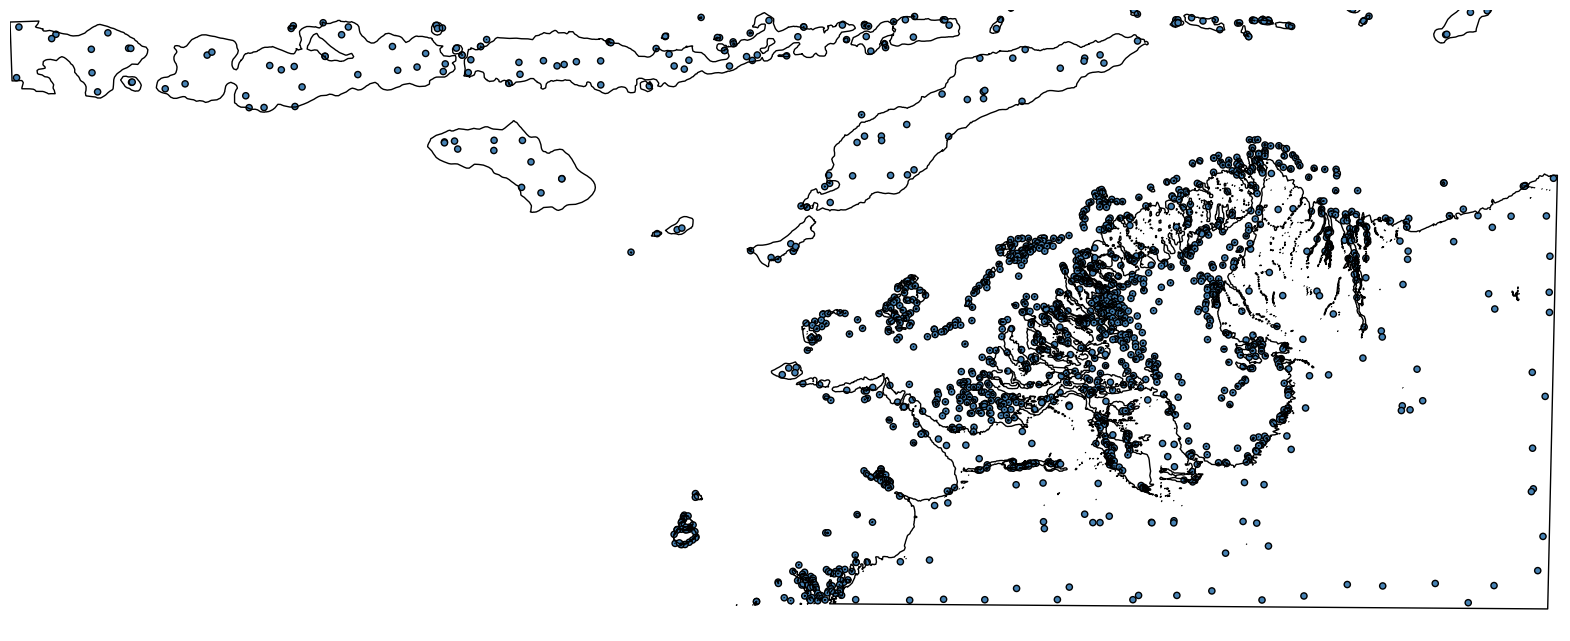

In [7]:
projection = gplt.crs.TransverseMercator()

ax = gplt.polyplot(islands, projection=projection, figsize=(20,20))
gplt.pointplot(island_viewpoints, ax=ax, projection=projection)
plt.show()

In [5]:
vs_re = re.compile(r'^viewshed_(\d{4})$')
folder = abspath('data/sl_-85/viewsheds/')
output_to = abspath(join('data/sl_-85', 'viewshed_polygons_chunked.shp'))

In [8]:
for viewshed_file in sorted(y for y in listdir(folder) if vs_re.match(y)):
    vs_num = int(vs_re.match(viewshed_file).group(1))
    raster_file = join(folder, viewshed_file)
    try:
        disaggregate_viewsheds_and_convert_to_polygons(raster_file, output_to, island_viewpoints, vs_num)
    except IndexError:
        continue

INFO:helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/sl_-85/viewsheds/viewshed_0001
INFO:helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/sl_-85/viewsheds/viewshed_0001 0
INFO:helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/sl_-85/viewsheds/viewshed_0001 50000
ERROR:rasterio._gdal:CPLE_AppDefined in AIGReadBlockIndex: Bad length
ERROR:rasterio._gdal:CPLE_AppDefined in /home/joshainglis/other_projects/papers/isea_interviz/data/sl_-85/viewsheds/viewshed_0001, band 1: IReadBlock failed at X offset 0, Y offset 650
ERROR:rasterio._gdal:CPLE_AppDefined in GetBlockRef failed at X block offset 0, Y block offset 650
INFO:helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/sl_-85/viewsheds/viewshed_0001 100000
INFO:helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/sl_-85/viewsheds/viewshed_0001 150000
ERROR:rasterio

In [140]:
poly_viewsheds = gpd.read_file(output_to)
poly_viewsheds['geometry'] = poly_viewsheds.buffer(0)
poly_viewsheds['area'] = poly_viewsheds.geometry.area
poly_viewsheds = poly_viewsheds.dissolve(by='FID_island')
poly_viewsheds_tmp = poly_viewsheds.geometry
poly_viewsheds_tmp.crs = {'init': 'epsg:4326'}
poly_viewsheds.geometry = poly_viewsheds_tmp
poly_viewsheds.to_file('data/sl_-85/poly_viewsheds_dissolved.shp')

In [8]:
poly_viewsheds = gpd.read_file('data/sl_-85/poly_viewsheds_dissolved.shp')

In [9]:
poly_viewsheds.head()

FID_point      area                                           geometry  \
0          0  0.003094  (POLYGON ((125.572735898502 -8.960893901035, 1...   
1          1  0.002437  (POLYGON ((129.757735898502 -8.680893901034999...   
2          2  0.000044  (POLYGON ((125.485235898502 -8.923393901034999...   
3          4  0.018506  (POLYGON ((121.325235898502 -8.858393901034999...   
4          5  0.013056  (POLYGON ((124.565235898502 -8.323393901034999...   

   raster_val  
0           1  
1           1  
2           1  
3           1  
4           1

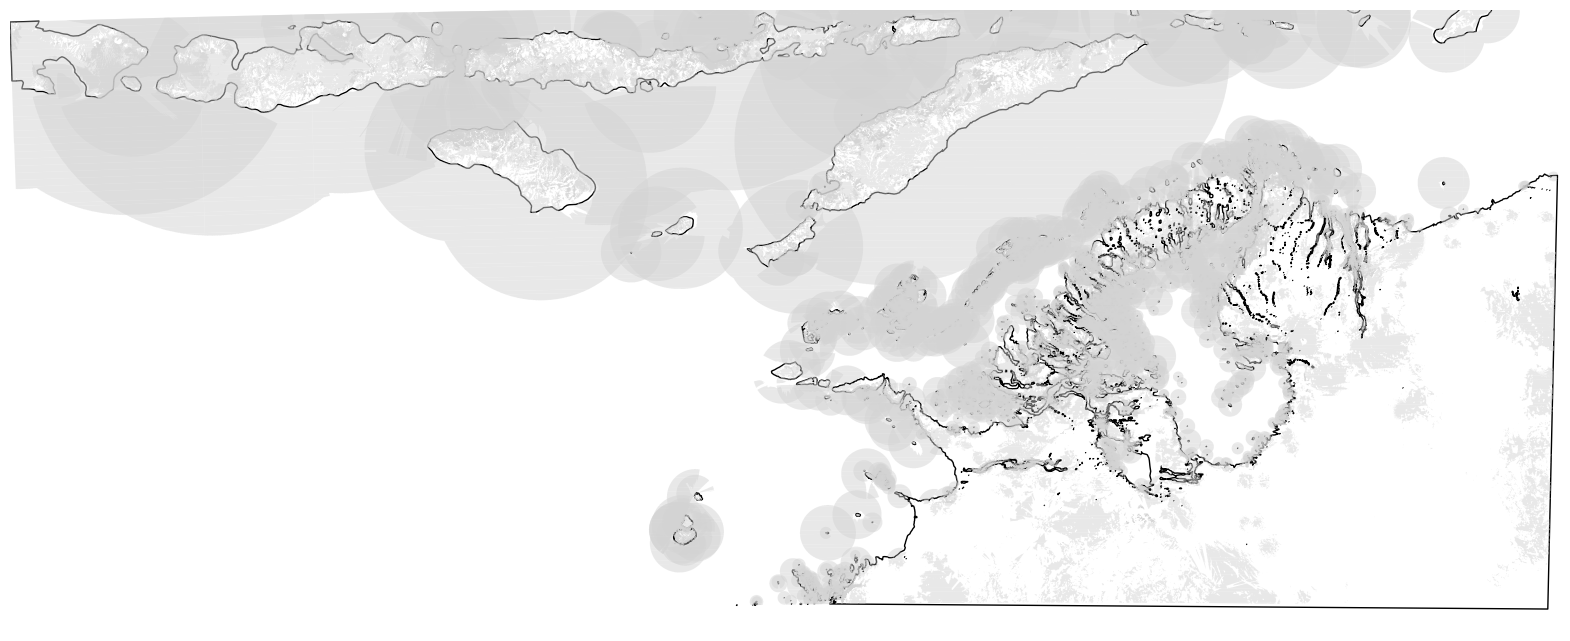

In [43]:
ax = gplt.polyplot(islands, projection=gplt.crs.TransverseMercator(), figsize=(20, 20))
gplt.polyplot(poly_viewsheds, projection=gplt.crs.TransverseMercator(), ax=ax, linewidth=0, facecolor='lightgray', alpha=0.5)
plt.show()

In [16]:
r = gpd.sjoin(islands, poly_viewsheds)
r.to_file('data/sl_-85/poly_viewsheds_joined.shp')

```bash
interviz-spatial-join data/sl_-85/islands_fixed.shp data/sl_-85/viewshed_polygons_chunked.shp data/sl_-85/poly_viewsheds_joined_2.shp
```

In [12]:
r = gpd.read_file('data/sl_-85/poly_viewsheds_joined.shp')

In [13]:
r['idx_island'] = r.Id - 1
r['idx_viewshed'] = r.index_righ
r_unique = r[r.idx_island != r.idx_viewshed]
r_unique = r_unique.reset_index().set_index(['idx_viewshed', 'idx_island'])
x = list({row[0] for i, row in r_unique.reset_index().iterrows()})

In [14]:
r.head()

FID_point  Id      area                                           geometry  \
0         48   1  0.004888  POLYGON ((125.742735898502 -8.060893901034945,...   
1         48   3  0.004888  POLYGON ((127.2102358985022 -8.110893901035013...   
2         48   5  0.004888  POLYGON ((124.6202358985021 -8.125893901034999...   
3         48  33  0.004888  POLYGON ((125.545235898502 -8.318393901034995,...   
4         48  60  0.004888  POLYGON ((124.105235898502 -8.558393901034947,...   

   gridcode  index_righ  raster_val  idx_island  idx_viewshed  
0         1          32           1           0            32  
1         1          32           1           2            32  
2         1          32           1           4            32  
3         1          32           1          32            32  
4         1          32           1          59            32

In [15]:
r_unique.head()

index  FID_point   Id      area  \
idx_viewshed idx_island                                    
32           0               0         48    1  0.004888   
             2               1         48    3  0.004888   
             4               2         48    5  0.004888   
             59              4         48   60  0.004888   
             189             5         48  190  0.004888   

                                                                  geometry  \
idx_viewshed idx_island                                                      
32           0           POLYGON ((125.742735898502 -8.060893901034945,...   
             2           POLYGON ((127.2102358985022 -8.110893901035013...   
             4           POLYGON ((124.6202358985021 -8.125893901034999...   
             59          POLYGON ((124.105235898502 -8.558393901034947,...   
             189         POLYGON ((123.612735898502 -10.04839390103501,...   

                         gridcode  index_righ  raster_val  
idx_viewshed idx_island                                    
32           0                  1          32           1  
             2                  1          32           1  
             4                  1          32           1  
             59                 1          32           1  
             189                1          32           1

In [14]:
r_unique.head()

index  FID_island  FID_point  Id  \
idx_viewshed idx_island                                     
58213        0               0         189        283   1   
8769         0               1          59         78   1   
58176        0               2         189        284   1   
8864         0               3          59         78   1   
24           0               4           0          0   1   

                                                                  geometry  \
idx_viewshed idx_island                                                      
58213        0           POLYGON ((125.742735898502 -8.060893901034945,...   
8769         0           POLYGON ((125.742735898502 -8.060893901034945,...   
58176        0           POLYGON ((125.742735898502 -8.060893901034945,...   
8864         0           POLYGON ((125.742735898502 -8.060893901034945,...   
24           0           POLYGON ((125.742735898502 -8.060893901034945,...   

                         index_righ  raster_val  
idx_viewshed idx_island                          
58213        0                58213           1  
8769         0                 8769           1  
58176        0                58176           1  
8864         0                 8864           1  
24           0                   24           1

In [22]:
islands.geometry = islands.buffer(0)
poly_viewsheds.geometry = poly_viewsheds.buffer(0)

G = nx.DiGraph()
for idx, (i, row) in enumerate(r_unique.reset_index().iterrows()):
    if i % 500 == 0:
        print(i)
    intersect = poly_viewsheds.loc[row['idx_viewshed']].geometry.intersection(islands.loc[row['idx_island']].geometry)
    G.add_edge(row['idx_viewshed'], row['idx_island'], area=intersect.area, region=intersect)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500


In [53]:
GG = nx.DiGraph()
for node_a, node_b in G.edges_iter():
    if node_a in G.edge[node_b]:
        GG.add_edge((node_a, node_b), (node_b, node_a))
        cab = G.edge[node_a][node_b]['region'].centroid
        GG.node[(node_a, node_b)]['coord'] = (cab.x, cab.y)

In [54]:
pos = {node: GG.node[node]['coord'] for node in GG.nodes_iter()}

In [69]:
g = gpd.GeoDataFrame([
    {
        'idx_a': node_a,
        'idx_b': node_b,
        'geometry': G[node_a][node_b]['region']
    } for node_a, node_b in GG.nodes_iter()
], geometry='geometry', crs=islands.crs)

In [70]:
g.crs

{'init': 'epsg:4326'}

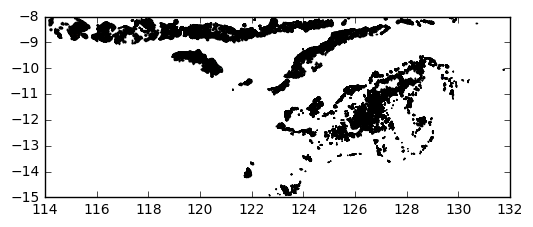

In [67]:
g.plot()

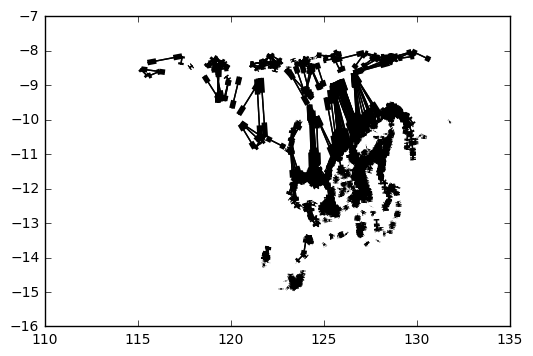

In [55]:
nx.draw_networkx_edges(GG, pos=pos)

In [24]:
rr = r_unique[['index_right']]

In [72]:
r_unique['geometry'] = r_unique.apply(lambda row: G[row.name[0]][row.name[1]]['region'], axis=1)

ValueError: Shape of passed values is (14782, 4), indices imply (14782, 5)

In [87]:
r_unique = r_unique[['geometry']].apply(lambda row: (G[row.name[0]][row.name[1]]['region'],), axis=1)

In [39]:
rr = gpd.GeoDataFrame(rr)

In [27]:
islands.head()

Id                                           geometry  FID
FID                                                            
0     1  POLYGON ((125.742735898502 -8.060893901034945,...    0
1     2  POLYGON ((129.767735898502 -8.06589390103494, ...    1
2     3  POLYGON ((127.2102358985022 -8.110893901035013...    2
3     4  POLYGON ((122.1327358985021 -8.125893901034999...    3
4     5  POLYGON ((124.6202358985021 -8.125893901034999...    4

FID_island    Z                                           geometry
FID                                                                    
0             0  161  POINT Z (125.7439858986305 -8.024643901794548 ...
1             1  289  POINT Z (129.7289858985805 -8.024643901794548 ...
2             2  227  POINT Z (127.1739858988302 -8.044643901394863 ...
3             2   87  POINT Z (127.2189858983807 -8.094643901294887 87)
4             3  166  POINT Z (122.1314858986553 -8.112143901619731 ...

In [34]:
r_unique.head()

FID_point   Id      area  \
0         48    1  0.004888   
1         48    3  0.004888   
2         48    5  0.004888   
4         48   60  0.004888   
5         48  190  0.004888   

                                            geometry  gridcode  index_righ  \
0  POLYGON ((125.742735898502 -8.060893901034945,...         1          32   
1  POLYGON ((127.2102358985022 -8.110893901035013...         1          32   
2  POLYGON ((124.6202358985021 -8.125893901034999...         1          32   
4  POLYGON ((124.105235898502 -8.558393901034947,...         1          32   
5  POLYGON ((123.612735898502 -10.04839390103501,...         1          32   

   raster_val  FID_island  idx_island  idx_viewshed  
0           1           0           0            32  
1           1           2           2            32  
2           1           4           4            32  
4           1          59          59            32  
5           1         189         189            32

In [28]:
for node in G.nodes_iter():
    c = r_unique.loc[node].geometry.centroid
    G.node[node]['coord'] = (c.x, c.y)
for node_a, node_b in G.edges_iter()

14783

In [29]:
pos = {node: G.node[node]['coord'] for node in G.nodes_iter()}

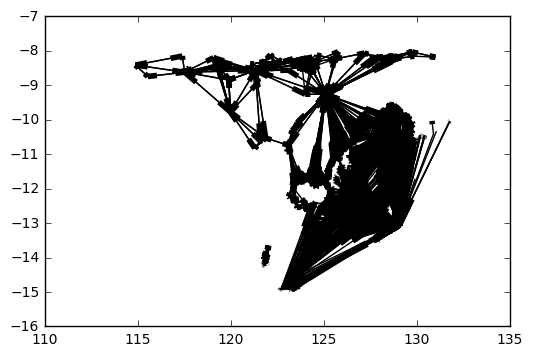

In [30]:
nx.draw_networkx_edges(G, pos=pos)

In [56]:
s, e = zip(*GG.edges_iter())
s = np.array(s)
e = np.array(e)
# gplt.sankey(start=islands.loc[s], end=islands.loc[e])

In [57]:
f, b = list(zip(e, s)), list(zip(s, e))

In [113]:
r_unique.centroid.loc[f]

index_right  index
32           0        POINT (125.7619072651938 -8.022816351954997)
59           0        POINT (125.7437447424986 -8.026258964776773)
189          0        POINT (125.7620756162693 -8.022250676757272)
28           1         POINT (129.705268013874 -8.034145361492842)
20           1        POINT (129.7069350769084 -8.024682371173208)
22           1        POINT (129.7535708858672 -8.034398594062623)
44           1        POINT (129.7326622230713 -8.009504619641815)
32           2        POINT (127.1638192318353 -8.050810567701655)
27           2        POINT (127.2007357728182 -8.065294618916621)
189          2        POINT (127.1777511213766 -8.073738078957851)
30           2        POINT (127.2054734983399 -8.064794202273804)
48           3        POINT (122.1242001462127 -8.119616734637741)
50           3        POINT (122.1238556373413 -8.118585065115621)
37           3        POINT (122.1239676015535 -8.119975577942023)
38           3        POINT (122.1220246318

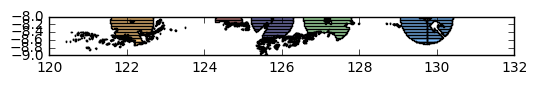

In [59]:
poly_viewsheds.head().plot()

In [91]:
gg = g.set_index(['idx_a', 'idx_b']).buffer(0)

In [129]:
gg[gg.apply(lambda x: not x.is_empty and x.area > 1e-9)].area.sort_values(ascending=True)

idx_a  idx_b
1171   1189     1.001365e-08
1172   1189     1.001365e-08
1177   1189     1.001365e-08
1176   1189     1.001365e-08
1133   1129     1.279145e-08
102    114      2.694553e-08
421    456      2.695312e-08
543    601      2.695312e-08
430    455      2.695312e-08
587    645      2.695312e-08
589    645      2.695312e-08
337    288      5.226279e-08
1237   1244     1.624429e-07
1238   1244     1.624429e-07
1232   1241     1.624429e-07
166    173      1.625102e-07
598    578      1.625776e-07
722    724      1.625776e-07
521    523      1.625776e-07
957    976      1.625776e-07
956    976      1.625776e-07
1025   1016     1.662098e-07
602    583      1.668731e-07
639    625      1.668731e-07
574    627      1.876951e-07
1025   1019     1.876951e-07
533    560      1.876951e-07
537    591      1.895307e-07
181    57       1.916952e-07
67     45       1.916952e-07
                    ...     
54     66       6.206622e-02
47     189      6.290000e-02
54     67       7.048119e-02
4

In [199]:
x = gg[gg.apply(lambda x: not x.is_empty and x.area > 1e-9)]
xa = gpd.GeoDataFrame(x.centroid, geometry=0, crs=islands.crs)
xa.columns = ['geometry']
xa_tmp = xa.reset_index()
xa_tmp['idx'] = xa_tmp.apply(lambda y: (y.idx_a, y.idx_b), axis=1)
xa_tmp['idx_other'] = xa_tmp.apply(lambda y: (y.idx_b, y.idx_a), axis=1)
xa_tmp = xa_tmp.set_index('idx')
paths = xa_tmp.join(xa_tmp, on='idx_other', lsuffix='_ab', rsuffix='_ba')
paths = paths[paths.apply(lambda y: y.geometry_ab is not np.nan and y.geometry_ba is not np.nan, axis=1)]

In [207]:
x[x.area == x.area.max()]

idx_a  idx_b
66     181      (POLYGON ((120.525235898502 -10.068393901035, ...
dtype: object

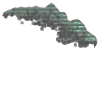

In [208]:
x.loc[(66, 181)]

In [ ]:
for i in x:
    try:
        if not x.is_valid:
            print(i)
    except:
        print(i)

Too few points in geometry component at or near point -34213.333100699805 76994.365408891361
Too few points in geometry component at or near point -34213.333100699805 76994.365408891361
Too few points in geometry component at or near point -107402.79533418639 -110133.97144869115
Too few points in geometry component at or near point -474721.96359735768 -287202.79398410325
Too few points in geometry component at or near point -289216.17363055289 -10605.43594103139
Too few points in geometry component at or near point -34213.333100699805 76994.365408891361
Too few points in geometry component at or near point -54734.250950006179 -213705.76180403051


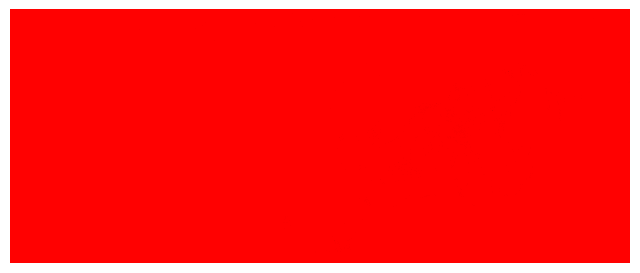

In [214]:
gplt.polyplot(
    x.simplify(2), 
    projection=proj, 
    linewidth=0, 
    facecolor='red', 
    alpha=0.3
)

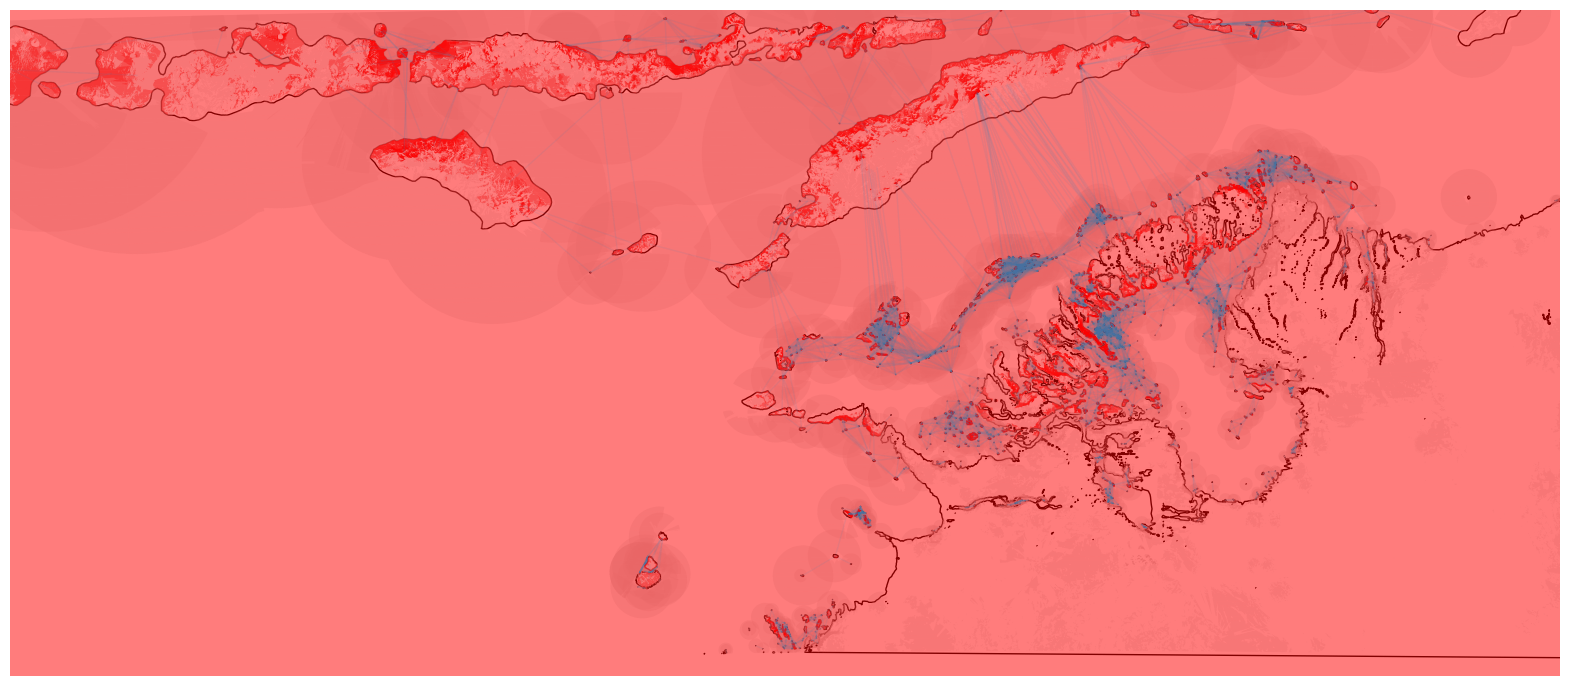

In [206]:
proj = gplt.crs.TransverseMercator()
ax = gplt.polyplot(
    islands, 
    projection=proj, 
    figsize=(20, 20), 
    color='darkgray'
)
gplt.polyplot(
    poly_viewsheds, 
    projection=proj, 
    ax=ax, 
    linewidth=0, 
    facecolor='lightgray', 
    alpha=0.3
)
gplt.polyplot(
    x, 
    projection=proj, 
    ax=ax, 
    linewidth=0, 
    facecolor='red', 
    alpha=0.3
)
gplt.sankey(
    paths, 
    start='geometry_ab', 
    end='geometry_ba', 
    ax=ax, 
    projection=proj, 
    alpha=0.05,
    rasterized=False
)


plt.savefig('interviz.pdf')
plt.show()

In [ ]:
plt.plot()

In [ ]:
x = gg[gg.apply(lambda x: not x.is_empty and x.area > 1e-9)]
xa = gpd.GeoDataFrame(x.centroid, geometry=0, crs=islands.crs)
xa.columns = ['geometry']
xa_tmp = xa.reset_index()
xa_tmp['idx'] = xa_tmp.apply(lambda y: (y.idx_a, y.idx_b), axis=1)
xa_tmp['idx_other'] = xa_tmp.apply(lambda y: (y.idx_b, y.idx_a), axis=1)
xa_tmp = xa_tmp.set_index('idx')
paths = xa_tmp.join(xa_tmp, on='idx_other', lsuffix='_ab', rsuffix='_ba')
paths = paths[paths.apply(lambda y: y.geometry_ab is not np.nan and y.geometry_ba is not np.nan, axis=1)]

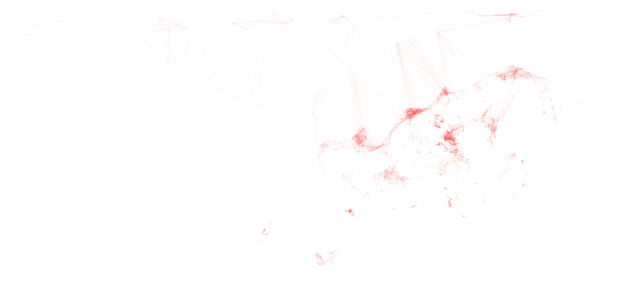

In [205]:
gplt.sankey(
    paths, 
    start='geometry_ab', 
    end='geometry_ba', 
#     ax=ax, 
    projection=proj, 
    alpha=0.01,
    color='red'
)

In [118]:
gg[gg.apply(lambda x: not x.is_empty)]

idx_a  idx_b
927    902      (POLYGON ((125.285235898502 -12.440893901035, ...
437    406      POLYGON ((126.507735898502 -11.03187986199528,...
43     3        POLYGON ((122.132735898502 -8.108393901034999,...
104    115      POLYGON ((128.3352358985021 -9.915893901034963...
1246   1247     (POLYGON ((123.3094054544428 -14.790893901035,...
124    110      (POLYGON ((129.2737866447615 -9.880893901035, ...
968    988      POLYGON ((125.4827358985023 -12.73589390103501...
678    667      POLYGON ((125.277735898502 -11.65359520212925,...
347    393      POLYGON ((128.102735898502 -11.000893901035, 1...
1032   1029     POLYGON ((124.6938314795568 -12.955893901035, ...
647    660      (POLYGON ((126.705235898502 -11.640893901035, ...
321    278      (POLYGON ((125.822735898502 -10.7096108872868,...
543    583      POLYGON ((126.950235898502 -11.50089390103473,...
967    891      POLYGON ((125.472735898502 -12.405893901035, 1...
898    938      POLYGON ((125.130235898502 -12.5356658874449, .

In [108]:
for x in gg:
    if x.is_empty:
        print(x)

POLYGON EMPTY
POLYGON EMPTY


In [153]:
rc = r_unique.copy()
rc['from'] = r_unique.centroid.loc[f]
rc['to'] = r_unique.centroid.loc[b].apply(lambda row: (row,))

In [152]:
rc = rc.to

In [140]:
rc.loc[b].head()

geometry
index_right index                                              
0           32     POINT (125.6042419059899 -8.216693859646917)
            59     POINT (125.0068434661167 -8.222921994796517)
            189     POINT (126.023752371104 -8.590301661496985)
1           28     POINT (128.9734510783919 -8.212909551607369)
            20     POINT (128.7399000631915 -8.178440180158013)

In [1]:
# ax = gplt.polyplot(islands, projection=gplt.crs.TransverseMercator(), figsize=(20, 20))
# gplt.polyplot(y, projection=gplt.crs.TransverseMercator(), ax=ax, linewidth=0, facecolor='lightgray', alpha=0.3)
gplt.sankey(start=rc['from'], end=rc['to'], projection=gplt.crs.TransverseMercator(), alpha=0.4)

NameError: name 'gplt' is not defined

FID
0       POINT (125.7619418607224 -8.022246080170657)
0       POINT (125.7619418607224 -8.022246080170657)
0       POINT (125.7619418607224 -8.022246080170657)
1       POINT (129.7381903495972 -8.029839325095688)
1       POINT (129.7381903495972 -8.029839325095688)
1       POINT (129.7381903495972 -8.029839325095688)
1       POINT (129.7381903495972 -8.029839325095688)
2        POINT (127.183450787513 -8.064602888323758)
2        POINT (127.183450787513 -8.064602888323758)
2        POINT (127.183450787513 -8.064602888323758)
2        POINT (127.183450787513 -8.064602888323758)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392

In [177]:
islands.iloc[0].geometry.centroid.y

-8.022246080170657

In [167]:
row[1]

1276

In [172]:
y.ix[row[1]]

geometry      (POLYGON ((123.570235898502 -14.920893901035, ...
FID_point                                                  1486
raster_val                                                    1
Name: 1276, dtype: object

In [166]:
row[1]
y.iloc[row[1]]
islands.iloc[row[0]].geometry

IndexError: single positional indexer is out-of-bounds

In [163]:
row

index            72
index_right    1276
Name: 1400, dtype: int64

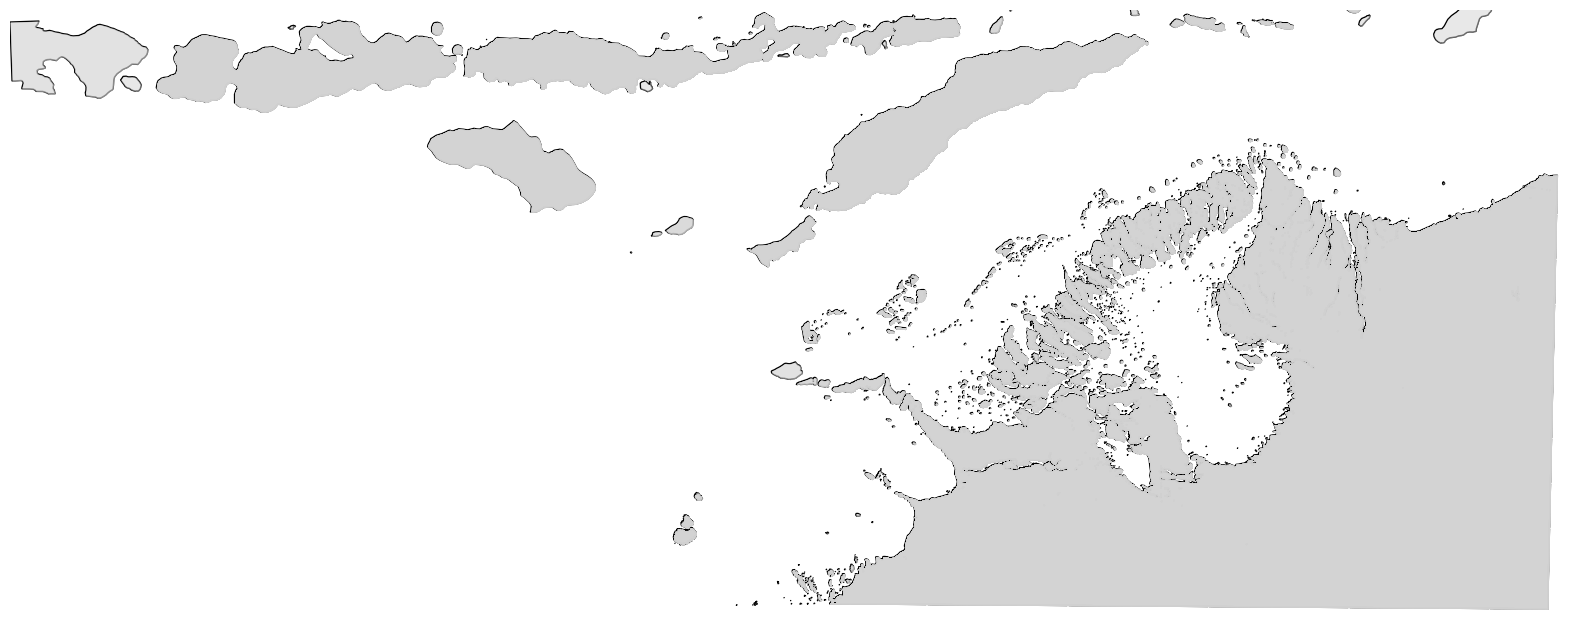

In [103]:
ax = gplt.polyplot(islands, projection=gplt.crs.TransverseMercator(), figsize=(20, 20))
gplt.polyplot(r_unique, projection=gplt.crs.TransverseMercator(), ax=ax, linewidth=0, facecolor='lightgray', alpha=0.3)

In [130]:
islands['geometry'] = islands.buffer(0)

In [143]:
islands.shape

(1277, 3)

In [144]:
y.shape

(1268, 3)

In [129]:
intersected = y.intersection(islands.buffer(0))

0       POLYGON ((125.760235898502 -8.039592896254529,...
1       (POLYGON ((129.760235898502 -8.043393901034998...
2       (POLYGON ((127.175235898502 -8.103393901035, 1...
3       POLYGON ((122.110235898502 -8.125045589614972,...
4       POLYGON ((124.6212182209325 -8.123393901034998...
5       POLYGON ((128.6827358985021 -8.15089390103492,...
6       POLYGON ((128.6827358985021 -8.15089390103492,...
7       POLYGON ((128.5627358985022 -8.160893901034967...
8       POLYGON ((128.7502358985022 -8.160893901034967...
9       (POLYGON ((128.5627358985023 -8.16089390103499...
10      (POLYGON ((128.7409435180143 -8.16089390103499...
11      (POLYGON ((128.7527358985021 -8.16089390103499...
12      (POLYGON ((128.5792836205527 -8.16089390103499...
13      POLYGON ((128.5845722986948 -8.165893901035, 1...
14      (POLYGON ((117.363935340719 -8.165893901035, 1...
15      POLYGON ((124.370235898502 -8.170893901034999,...
16      POLYGON ((128.3879314117754 -8.190893901034999...
17      (POLYG

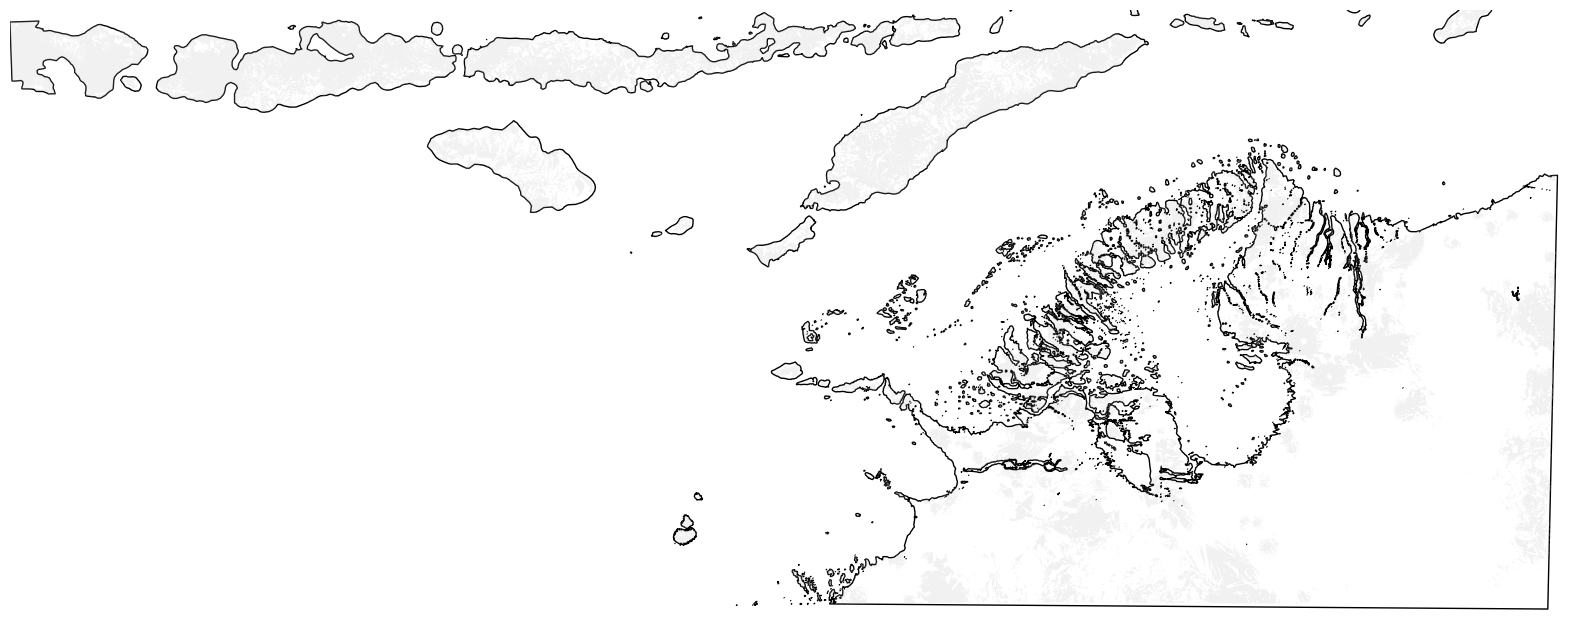

In [142]:
ax = gplt.polyplot(islands, projection=gplt.crs.TransverseMercator(), figsize=(20, 20))
gplt.polyplot(intersected[intersected.area > 0].buffer(0), projection=gplt.crs.TransverseMercator(), ax=ax, linewidth=0, facecolor='lightgray', alpha=0.3)